Options:
1. Add retraining user features: In the 2nd train, fix Q, only train P.
2. Add Neighbor Based Correction of MF (Takacs et al., 2009)

In [6]:
import numpy as np
import pandas as pd
import math
from itertools import product
from tqdm import tqdm
import pickle
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
rating_df = pd.read_csv('../data/cleaned/cleaned_user_rating.csv')
rating_df_copy = rating_df.copy()
movies_df = pd.read_csv('../data/cleaned/cleaned_movies_details.csv', usecols=['movie_id', 'title', 'genres', 'overview', 'director', 'stars', 'img_url'])

# ID to number
rating_df_copy['user_id_number'] = rating_df_copy['user_id'].astype('category').cat.codes.values
rating_df_copy['movie_id_number'] = rating_df_copy['movie_id'].astype('category').cat.codes.values
# rating_df_copy = rating_df_copy.groupby('movie_id') \
# .filter(lambda x : len(x) >= 30) # 15

train_data = rating_df_copy[['user_id_number', 'movie_id_number', 'rating']].values
print(train_data)

[[ 35310  17908      8]
 [142632  17908      8]
 [ 47533  17908      1]
 ...
 [153329   6675      8]
 [ 40272   6675      7]
 [ 27285   6675      9]]


In [14]:
movies_df['genres'] = movies_df['genres'].str.replace(',',' ')
movies_df['genres'] = movies_df['genres'].str.replace('Sci-Fi','SciFi')
movies_df['genres'] = movies_df['genres'].str.replace('Film-Noir','FilmNoir')
movies_df['genres'] = movies_df['genres'].str.replace('Reality-TV','RealityTV')
movies_df['genres'] = movies_df['genres'].str.replace('Talk-Show','TalkShow')

In [11]:
# Load a pre-trained SentenceTransformer model
model = SentenceTransformer('all-mpnet-base-v2')
# Update content creation for semantic embeddings
movies_df['content'] = movies_df.apply(
    lambda x: f"{x['title']} is a {x['genres']} movie directed by {x['director']} starring {x['stars']}. Overview: {x['overview']}",
    axis=1
)
# Create transformer embeddings
transformer_embeddings = model.encode(movies_df['content'].tolist(), show_progress_bar=True)
# Compute cosine similarity matrix
sim_matrix = cosine_similarity(transformer_embeddings)
np.save('./sim_matrix.npy', sim_matrix)

NameError: name 'SentenceTransformer' is not defined

In [15]:
display(rating_df_copy)
# Build the mappings
number_to_user_id = dict(enumerate(rating_df_copy['user_id'].astype('category').cat.categories))
user_id_to_number = {v: k for k, v in number_to_user_id.items()}
number_to_movie_id = dict(enumerate(rating_df_copy['movie_id'].astype('category').cat.categories))
movie_id_to_number = {v: k for k, v in number_to_movie_id.items()}
# Example: Get user_id_number for a specific user_id
user_id = 'ur127508339'  
user_id_number = user_id_to_number[user_id]
print(user_id_number)
print(movie_id_to_number['tt7737800'])
# Example: Get user_id for a specific user_id_number
user_id_number = 35310  
user_id = number_to_user_id[user_id_number]
print(user_id)

,user_id,movie_id,rating,user_id_number,movie_id_number
0,ur127508339,tt7737800,8,35310,17908
1,ur6312156,tt7737800,8,142632,17908
2,ur150453978,tt7737800,1,47533,17908
3,ur18519281,tt7737800,3,65860,17908
4,ur0806494,tt7737800,7,13774,17908
...,...,...,...,...,...
376010,ur15148330,tt0062292,8,48045,1505
376011,ur1793363,tt0158610,9,62806,6675
376012,ur7242773,tt0158610,8,153329,6675
376013,ur134486398,tt0158610,7,40272,6675


35310
17908
ur127508339


In [16]:
def get_movieURL(movie_id):
    return movies_df[movies_df.movie_id == movie_id].img_url.values[0]

print(get_movieURL('tt7737800'))

https://m.media-amazon.com/images/M/MV5BYzliNzRjNDMtYTFmOS00NDQxLWJlOWMtZTViNjcyMzc0NzQwXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg


In [17]:
def split_ratings_by_user(train_data, random_state=420):
    """
    Split ratings for each user into train, validation, and test sets
    with 60:20:20 split and maintaining rating count distribution
    """
    np.random.seed(random_state)
    
    # Unique users
    users = np.unique(train_data[:, 0])
    
    # Initialize empty lists for split data
    train_data_list = []
    val_data_list = []
    test_data_list = []
    
    for user in users:
        user_ratings = train_data[train_data[:, 0] == user]
        # Sort ratings in ascending order (assuming they are sorted by timestamp or order)
        user_ratings = user_ratings[user_ratings[:, 2].argsort()]
        total_ratings = len(user_ratings)
        train_end = math.ceil(total_ratings * 0.6)
        val_end = train_end + math.ceil(total_ratings * 0.2)
        
        # Split the data
        train_data_list.append(user_ratings[:train_end])
        val_data_list.append(user_ratings[train_end:val_end])
        test_data_list.append(user_ratings[val_end:])
    
    # Concatenate the lists
    train_data = np.vstack(train_data_list)
    val_data = np.vstack(val_data_list)
    test_data = np.vstack(test_data_list)
    
    return train_data, val_data, test_data

In [9]:
# train_data, val_data, test_data = split_ratings_by_user(train_data)
# np.savez_compressed('../cleaned_data/data.npz', train=train_data, val=val_data, test=test_data)

In [18]:
def evaluate_recommendation(cf_model, test_data, n_top=5):
    hit_ratios, ndcg_scores = [], []
    
    for u in np.unique(test_data[:, 0]):
        # Get movies with ratings 8-10 in test data
        user_test_ratings = test_data[test_data[:, 0] == u]
        high_rated_test_movies = user_test_ratings[user_test_ratings[:, 2] >= 8, 1]
        
        if len(high_rated_test_movies) != 0:
            # Get all unrated movies
            train_movies = cf_model.train_data[cf_model.train_data[:, 0] == u, 1]
            all_movies = np.arange(cf_model.n_movies)
            unrated_movies = all_movies[~np.isin(all_movies, np.concatenate([train_movies, user_test_ratings[:, 1]]))]
            
            # Combine the high-rated movie with 99 other unrated movies
            sampled_unrated_movies = np.random.choice(unrated_movies, 99, replace=False)
            
            hit_ratio = 0
            dcg = 0
            # For each high-rated test movie
            for high_rated_movie in high_rated_test_movies:
                
                candidate_movies = np.concatenate([[high_rated_movie], sampled_unrated_movies])
                movie_scores = {i: cf_model.pred(u, i) for i in candidate_movies}
                
                # Sort movies by predicted score
                sorted_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:n_top]
                
                # Calculate the benchmark
                if high_rated_movie in sorted_movies:
                    hit_ratio += 1 
                    rank = sorted_movies.index(high_rated_movie) + 1
                    dcg += 1 / math.log2(rank + 1)  # Discount for rank
            hit_ratios.append(hit_ratio / len(high_rated_test_movies))
            ndcg_scores.append(dcg / len(high_rated_test_movies))
            
    return np.mean(hit_ratios), np.mean(ndcg_scores)

In [19]:
def load_model(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [12]:
data = np.load('../cleaned_data/data.npz')
train_data = data['train']
val_data = data['val']
test_data = data['test']

In [ ]:
print(train_data)

## ISMF

In [13]:
class ISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1 
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                self.P[u, :] += self.learning_rate * error * self.Q[i, :]
                self.Q[i, :] += self.learning_rate * error * self.P[u, :]
            
            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break

    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            # Update P and Q
            self.P[u, :] += self.learning_rate * error * self.Q[i, :]
            self.Q[i, :] += self.learning_rate * error * self.P[u, :]

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        urls = []

        for i in recommended_items:
            movie_id = number_to_movie_id[i]
            urls.append(get_movieURL(movie_id))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)
                
        # # Visualization of prediction values distribution
        # pred_values = list(recommended_items.values())
        
        # # Create figure and axis
        # plt.figure(figsize=(10, 6))
        
        # # Option 1: Histogram
        # plt.hist(pred_values, bins=50, edgecolor='black')
        # plt.title(f'Distribution of Predicted Ratings for User {u}')
        # plt.xlabel('Predicted Rating')
        # plt.ylabel('Frequency')
        # plt.show()
        
        # # Option 2: Density plot using seaborn
        # plt.figure(figsize=(10, 6))
        # sns.kdeplot(data=pred_values, fill=True)
        # plt.title(f'Density Distribution of Predicted Ratings for User {u}')
        # plt.xlabel('Predicted Rating')
        # plt.ylabel('Density')
        # plt.show()
        
        # # Optional: Print basic statistics
        # print(f"Mean prediction: {np.mean(pred_values):.2f}")
        # print(f"Median prediction: {np.median(pred_values):.2f}")
        # print(f"Standard deviation: {np.std(pred_values):.2f}")
        # print(f"Min prediction: {min(pred_values):.2f}")
        # print(f"Max prediction: {max(pred_values):.2f}")

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

In [14]:
# cf_model = ISMF(train_data, n_factors=2, learning_rate=1e-4, n_epochs=100)
# cf_model.print_recommendation('ur127508339')
# # Add new ratings incrementally
# new_ratings = np.array([['ur127508339', 'tt0062292', 3], ['ur6969', 'tt6969', 7]])  # Example new ratings
# cf_model.incremental_update(new_ratings)

In [15]:
# Hyperparameter grid
n_factors_list = [5, 10, 20, 50] # [5, 10, 20, 50]
learning_rates = [1e-3, 1e-2, 5e-2, 1e-1] # [1e-3, 1e-2, 5e-2, 1e-1]

# Open the CSV file and write the header once
csv_file_path = '../results/ismf_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = ISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, n_epochs=100)
    print(f"ismf, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../models/ismf/ismf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

ismf, n_factors: 5, learning_rate: 0.001


KeyboardInterrupt: 

## RISMF

In [ ]:
class RISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1
         
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                # Update P and Q
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
                self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
                
    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            # Update P and Q
            self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
            self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        urls = []

        for i in recommended_items:
            movie_id = number_to_movie_id[i]
            urls.append(get_movieURL(movie_id))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

In [ ]:
# Hyperparameter grid
n_factors_list = [5, 10, 20, 50] # [5, 10, 20, 50]
learning_rates = [1e-3, 1e-2, 5e-2, 1e-1] # [1e-3, 1e-2, 5e-2, 1e-1]

# Open the CSV file and write the header once
csv_file_path = '../results/rismf_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = RISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
    print(f"rismf, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../models/rismf/rismf_nf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

rismf, n_factors: 5, learning_rate: 0.001


Epoch 1/100: 100%|██████████| 300578/300578 [00:05<00:00, 59731.82rating/s]


Train loss: 6.0928
Test loss: 8.1319


Epoch 2/100: 100%|██████████| 300578/300578 [00:05<00:00, 60054.20rating/s]


Train loss: 6.0903
Test loss: 8.1319


Epoch 3/100: 100%|██████████| 300578/300578 [00:05<00:00, 59379.51rating/s]


Train loss: 6.0879
Test loss: 8.1319


Epoch 4/100: 100%|██████████| 300578/300578 [00:05<00:00, 57240.81rating/s]


Train loss: 6.0855
Test loss: 8.1319


Epoch 5/100: 100%|██████████| 300578/300578 [00:05<00:00, 57408.14rating/s]


Train loss: 6.0831
Test loss: 8.1319


Epoch 6/100: 100%|██████████| 300578/300578 [00:05<00:00, 59498.35rating/s]


Train loss: 6.0806
Test loss: 8.1319


Epoch 7/100: 100%|██████████| 300578/300578 [00:04<00:00, 60604.93rating/s]


Train loss: 6.0781
Test loss: 8.1318


Epoch 8/100: 100%|██████████| 300578/300578 [00:05<00:00, 59689.23rating/s]


Train loss: 6.0755
Test loss: 8.1318


Epoch 9/100: 100%|██████████| 300578/300578 [00:04<00:00, 60148.99rating/s]


Train loss: 6.0729
Test loss: 8.1318


Epoch 10/100: 100%|██████████| 300578/300578 [00:05<00:00, 59698.09rating/s]


Train loss: 6.0702
Test loss: 8.1318


Epoch 11/100: 100%|██████████| 300578/300578 [00:05<00:00, 58967.64rating/s]


Train loss: 6.0673
Test loss: 8.1317


Epoch 12/100: 100%|██████████| 300578/300578 [00:04<00:00, 60555.97rating/s]


Train loss: 6.0644
Test loss: 8.1316


Epoch 13/100: 100%|██████████| 300578/300578 [00:04<00:00, 60496.00rating/s]


Train loss: 6.0613
Test loss: 8.1315


Epoch 14/100: 100%|██████████| 300578/300578 [00:04<00:00, 60191.71rating/s]


Train loss: 6.0580
Test loss: 8.1313


Epoch 15/100: 100%|██████████| 300578/300578 [00:05<00:00, 60001.47rating/s]


Train loss: 6.0546
Test loss: 8.1310


Epoch 16/100: 100%|██████████| 300578/300578 [00:05<00:00, 59873.21rating/s]


Train loss: 6.0509
Test loss: 8.1306


Epoch 17/100: 100%|██████████| 300578/300578 [00:05<00:00, 59546.05rating/s]


Train loss: 6.0470
Test loss: 8.1301


Epoch 18/100: 100%|██████████| 300578/300578 [00:04<00:00, 61556.78rating/s]


Train loss: 6.0428
Test loss: 8.1293


Epoch 19/100: 100%|██████████| 300578/300578 [00:04<00:00, 60929.39rating/s]


Train loss: 6.0381
Test loss: 8.1283


Epoch 20/100: 100%|██████████| 300578/300578 [00:05<00:00, 59873.16rating/s]


Train loss: 6.0331
Test loss: 8.1269


Epoch 21/100: 100%|██████████| 300578/300578 [00:04<00:00, 60495.96rating/s]


Train loss: 6.0276
Test loss: 8.1250


Epoch 22/100: 100%|██████████| 300578/300578 [00:04<00:00, 60285.20rating/s]


Train loss: 6.0214
Test loss: 8.1225


Epoch 23/100: 100%|██████████| 300578/300578 [00:05<00:00, 59984.54rating/s]


Train loss: 6.0146
Test loss: 8.1191


Epoch 24/100: 100%|██████████| 300578/300578 [00:04<00:00, 60716.42rating/s]


Train loss: 6.0070
Test loss: 8.1149


Epoch 25/100: 100%|██████████| 300578/300578 [00:04<00:00, 60672.27rating/s]


Train loss: 5.9986
Test loss: 8.1094


Epoch 26/100: 100%|██████████| 300578/300578 [00:04<00:00, 61261.09rating/s]


Train loss: 5.9892
Test loss: 8.1025


Epoch 27/100: 100%|██████████| 300578/300578 [00:04<00:00, 60549.13rating/s]


Train loss: 5.9787
Test loss: 8.0939


Epoch 28/100: 100%|██████████| 300578/300578 [00:04<00:00, 61184.78rating/s]


Train loss: 5.9673
Test loss: 8.0836


Epoch 29/100: 100%|██████████| 300578/300578 [00:04<00:00, 60849.44rating/s]


Train loss: 5.9547
Test loss: 8.0713


Epoch 30/100: 100%|██████████| 300578/300578 [00:04<00:00, 60577.60rating/s]


Train loss: 5.9412
Test loss: 8.0570


Epoch 31/100: 100%|██████████| 300578/300578 [00:05<00:00, 60050.32rating/s]


Train loss: 5.9267
Test loss: 8.0407


Epoch 32/100: 100%|██████████| 300578/300578 [00:04<00:00, 60520.19rating/s]


Train loss: 5.9114
Test loss: 8.0225


Epoch 33/100: 100%|██████████| 300578/300578 [00:05<00:00, 60100.29rating/s]


Train loss: 5.8953
Test loss: 8.0025


Epoch 34/100: 100%|██████████| 300578/300578 [00:05<00:00, 59926.46rating/s]


Train loss: 5.8785
Test loss: 7.9811


Epoch 35/100: 100%|██████████| 300578/300578 [00:04<00:00, 60285.89rating/s]


Train loss: 5.8611
Test loss: 7.9583


Epoch 36/100: 100%|██████████| 300578/300578 [00:04<00:00, 60546.70rating/s]


Train loss: 5.8432
Test loss: 7.9345


Epoch 37/100: 100%|██████████| 300578/300578 [00:04<00:00, 60408.15rating/s]


Train loss: 5.8249
Test loss: 7.9098


Epoch 38/100: 100%|██████████| 300578/300578 [00:04<00:00, 60960.41rating/s]


Train loss: 5.8062
Test loss: 7.8846


Epoch 39/100: 100%|██████████| 300578/300578 [00:04<00:00, 61377.52rating/s]


Train loss: 5.7872
Test loss: 7.8589


Epoch 40/100: 100%|██████████| 300578/300578 [00:05<00:00, 59313.16rating/s]


Train loss: 5.7678
Test loss: 7.8330


Epoch 41/100: 100%|██████████| 300578/300578 [00:05<00:00, 59193.72rating/s]


Train loss: 5.7480
Test loss: 7.8068


Epoch 42/100: 100%|██████████| 300578/300578 [00:04<00:00, 60716.27rating/s]


Train loss: 5.7278
Test loss: 7.7806


Epoch 43/100: 100%|██████████| 300578/300578 [00:04<00:00, 60425.89rating/s]


Train loss: 5.7073
Test loss: 7.7543


Epoch 44/100: 100%|██████████| 300578/300578 [00:05<00:00, 59268.88rating/s]


Train loss: 5.6863
Test loss: 7.7280


Epoch 45/100: 100%|██████████| 300578/300578 [00:04<00:00, 60761.98rating/s]


Train loss: 5.6649
Test loss: 7.7018


Epoch 46/100: 100%|██████████| 300578/300578 [00:04<00:00, 61129.08rating/s]


Train loss: 5.6431
Test loss: 7.6756


Epoch 47/100: 100%|██████████| 300578/300578 [00:05<00:00, 60066.28rating/s]


Train loss: 5.6207
Test loss: 7.6493


Epoch 48/100: 100%|██████████| 300578/300578 [00:05<00:00, 59475.86rating/s]


Train loss: 5.5979
Test loss: 7.6233


Epoch 49/100: 100%|██████████| 300578/300578 [00:04<00:00, 60484.54rating/s]


Train loss: 5.5746
Test loss: 7.5975


Epoch 50/100: 100%|██████████| 300578/300578 [00:04<00:00, 61611.70rating/s]


Train loss: 5.5507
Test loss: 7.5715


Epoch 51/100: 100%|██████████| 300578/300578 [00:04<00:00, 60464.95rating/s]


Train loss: 5.5263
Test loss: 7.5459


Epoch 52/100: 100%|██████████| 300578/300578 [00:04<00:00, 60488.92rating/s]


Train loss: 5.5014
Test loss: 7.5203


Epoch 53/100: 100%|██████████| 300578/300578 [00:05<00:00, 59723.44rating/s]


Train loss: 5.4759
Test loss: 7.4949


Epoch 54/100: 100%|██████████| 300578/300578 [00:04<00:00, 60706.32rating/s]


Train loss: 5.4498
Test loss: 7.4698


Epoch 55/100: 100%|██████████| 300578/300578 [00:04<00:00, 60922.83rating/s]


Train loss: 5.4231
Test loss: 7.4448


Epoch 56/100: 100%|██████████| 300578/300578 [00:05<00:00, 59674.62rating/s]


Train loss: 5.3958
Test loss: 7.4201


Epoch 57/100: 100%|██████████| 300578/300578 [00:05<00:00, 59586.10rating/s]


Train loss: 5.3679
Test loss: 7.3954


Epoch 58/100: 100%|██████████| 300578/300578 [00:04<00:00, 60267.52rating/s]


Train loss: 5.3393
Test loss: 7.3711


Epoch 59/100: 100%|██████████| 300578/300578 [00:05<00:00, 59928.46rating/s]


Train loss: 5.3101
Test loss: 7.3470


Epoch 60/100: 100%|██████████| 300578/300578 [00:04<00:00, 60446.00rating/s]


Train loss: 5.2803
Test loss: 7.3232


Epoch 61/100: 100%|██████████| 300578/300578 [00:05<00:00, 59897.31rating/s]


Train loss: 5.2497
Test loss: 7.2998


Epoch 62/100: 100%|██████████| 300578/300578 [00:04<00:00, 61063.45rating/s]


Train loss: 5.2186
Test loss: 7.2766


Epoch 63/100: 100%|██████████| 300578/300578 [00:04<00:00, 60990.73rating/s]


Train loss: 5.1867
Test loss: 7.2533


Epoch 64/100: 100%|██████████| 300578/300578 [00:04<00:00, 60232.30rating/s]


Train loss: 5.1542
Test loss: 7.2307


Epoch 65/100: 100%|██████████| 300578/300578 [00:05<00:00, 59953.19rating/s]


Train loss: 5.1210
Test loss: 7.2084


Epoch 66/100: 100%|██████████| 300578/300578 [00:04<00:00, 60274.89rating/s]


Train loss: 5.0871
Test loss: 7.1863


Epoch 67/100: 100%|██████████| 300578/300578 [00:05<00:00, 60100.26rating/s]


Train loss: 5.0526
Test loss: 7.1642


Epoch 68/100: 100%|██████████| 300578/300578 [00:05<00:00, 59912.50rating/s]


Train loss: 5.0174
Test loss: 7.1427


Epoch 69/100: 100%|██████████| 300578/300578 [00:05<00:00, 59668.46rating/s]


Train loss: 4.9815
Test loss: 7.1213


Epoch 70/100: 100%|██████████| 300578/300578 [00:04<00:00, 60147.61rating/s]


Train loss: 4.9450
Test loss: 7.1005


Epoch 71/100: 100%|██████████| 300578/300578 [00:05<00:00, 59176.17rating/s]


Train loss: 4.9079
Test loss: 7.0795


Epoch 72/100: 100%|██████████| 300578/300578 [00:05<00:00, 59074.54rating/s]


Train loss: 4.8701
Test loss: 7.0591


Epoch 73/100: 100%|██████████| 300578/300578 [00:04<00:00, 61096.17rating/s]


Train loss: 4.8317
Test loss: 7.0391


Epoch 74/100: 100%|██████████| 300578/300578 [00:04<00:00, 61159.91rating/s]


Train loss: 4.7928
Test loss: 7.0195


Epoch 75/100: 100%|██████████| 300578/300578 [00:04<00:00, 60286.05rating/s]


Train loss: 4.7532
Test loss: 6.9997


Epoch 76/100: 100%|██████████| 300578/300578 [00:04<00:00, 60936.36rating/s]


Train loss: 4.7131
Test loss: 6.9808


Epoch 77/100: 100%|██████████| 300578/300578 [00:04<00:00, 60968.85rating/s]


Train loss: 4.6724
Test loss: 6.9617


Epoch 78/100: 100%|██████████| 300578/300578 [00:04<00:00, 60828.33rating/s]


Train loss: 4.6313
Test loss: 6.9428


Epoch 79/100: 100%|██████████| 300578/300578 [00:05<00:00, 59961.85rating/s]


Train loss: 4.5896
Test loss: 6.9244


Epoch 80/100: 100%|██████████| 300578/300578 [00:05<00:00, 59686.21rating/s]


Train loss: 4.5475
Test loss: 6.9062


Epoch 81/100: 100%|██████████| 300578/300578 [00:04<00:00, 60260.88rating/s]


Train loss: 4.5049
Test loss: 6.8889


Epoch 82/100: 100%|██████████| 300578/300578 [00:04<00:00, 60236.20rating/s]


Train loss: 4.4619
Test loss: 6.8716


Epoch 83/100: 100%|██████████| 300578/300578 [00:05<00:00, 59587.08rating/s]


Train loss: 4.4185
Test loss: 6.8540


Epoch 84/100: 100%|██████████| 300578/300578 [00:04<00:00, 60494.87rating/s]


Train loss: 4.3748
Test loss: 6.8372


Epoch 85/100: 100%|██████████| 300578/300578 [00:04<00:00, 60641.49rating/s]


Train loss: 4.3307
Test loss: 6.8209


Epoch 86/100: 100%|██████████| 300578/300578 [00:05<00:00, 59962.73rating/s]


Train loss: 4.2864
Test loss: 6.8047


Epoch 87/100: 100%|██████████| 300578/300578 [00:05<00:00, 59636.14rating/s]


Train loss: 4.2417
Test loss: 6.7890


Epoch 88/100: 100%|██████████| 300578/300578 [00:04<00:00, 60864.86rating/s]


Train loss: 4.1968
Test loss: 6.7733


Epoch 89/100: 100%|██████████| 300578/300578 [00:04<00:00, 60983.60rating/s]


Train loss: 4.1517
Test loss: 6.7575


Epoch 90/100: 100%|██████████| 300578/300578 [00:05<00:00, 59960.81rating/s]


Train loss: 4.1064
Test loss: 6.7428


Epoch 91/100: 100%|██████████| 300578/300578 [00:05<00:00, 59645.80rating/s]


Train loss: 4.0610
Test loss: 6.7281


Epoch 92/100: 100%|██████████| 300578/300578 [00:04<00:00, 60547.96rating/s]


Train loss: 4.0154
Test loss: 6.7131


Epoch 93/100: 100%|██████████| 300578/300578 [00:04<00:00, 60625.20rating/s]


Train loss: 3.9697
Test loss: 6.6985


Epoch 94/100: 100%|██████████| 300578/300578 [00:04<00:00, 60162.65rating/s]


Train loss: 3.9241
Test loss: 6.6856


Epoch 95/100: 100%|██████████| 300578/300578 [00:04<00:00, 61150.83rating/s]


Train loss: 3.8783
Test loss: 6.6717


Epoch 96/100: 100%|██████████| 300578/300578 [00:05<00:00, 59934.43rating/s]


Train loss: 3.8325
Test loss: 6.6586


Epoch 97/100: 100%|██████████| 300578/300578 [00:04<00:00, 61120.82rating/s]


Train loss: 3.7868
Test loss: 6.6451


Epoch 98/100: 100%|██████████| 300578/300578 [00:04<00:00, 60288.98rating/s]


Train loss: 3.7411
Test loss: 6.6319


Epoch 99/100: 100%|██████████| 300578/300578 [00:04<00:00, 60608.55rating/s]


Train loss: 3.6956
Test loss: 6.6194


Epoch 100/100: 100%|██████████| 300578/300578 [00:04<00:00, 60433.70rating/s]


Train loss: 3.6501
Test loss: 6.6075
Results - n_factors: 5, learning_rate: 0.001, HR: 0.0649, NDCG: 0.0378
rismf, n_factors: 5, learning_rate: 0.01


Epoch 1/100: 100%|██████████| 300578/300578 [00:05<00:00, 60012.97rating/s]


Train loss: 6.0697
Test loss: 8.1331


Epoch 2/100: 100%|██████████| 300578/300578 [00:04<00:00, 60439.33rating/s]


Train loss: 6.0327
Test loss: 8.1304


Epoch 3/100: 100%|██████████| 300578/300578 [00:04<00:00, 61010.02rating/s]


Train loss: 5.9525
Test loss: 8.0918


Epoch 4/100: 100%|██████████| 300578/300578 [00:05<00:00, 59963.71rating/s]


Train loss: 5.7683
Test loss: 7.8936


Epoch 5/100: 100%|██████████| 300578/300578 [00:04<00:00, 60153.38rating/s]


Train loss: 5.5061
Test loss: 7.5911


Epoch 6/100: 100%|██████████| 300578/300578 [00:05<00:00, 59978.32rating/s]


Train loss: 5.1779
Test loss: 7.2999


Epoch 7/100: 100%|██████████| 300578/300578 [00:04<00:00, 60938.21rating/s]


Train loss: 4.7782
Test loss: 7.0401


Epoch 8/100: 100%|██████████| 300578/300578 [00:04<00:00, 60224.31rating/s]


Train loss: 4.3220
Test loss: 6.8238


Epoch 9/100: 100%|██████████| 300578/300578 [00:04<00:00, 60971.14rating/s]


Train loss: 3.8369
Test loss: 6.6436


Epoch 10/100: 100%|██████████| 300578/300578 [00:04<00:00, 60320.91rating/s]


Train loss: 3.3566
Test loss: 6.5006


Epoch 11/100: 100%|██████████| 300578/300578 [00:04<00:00, 60320.86rating/s]


Train loss: 2.9095
Test loss: 6.3815


Epoch 12/100: 100%|██████████| 300578/300578 [00:05<00:00, 59175.50rating/s]


Train loss: 2.5151
Test loss: 6.2827


Epoch 13/100: 100%|██████████| 300578/300578 [00:04<00:00, 61070.97rating/s]


Train loss: 2.1822
Test loss: 6.2200


Epoch 14/100: 100%|██████████| 300578/300578 [00:05<00:00, 59780.67rating/s]


Train loss: 1.9109
Test loss: 6.1630


Epoch 15/100: 100%|██████████| 300578/300578 [00:04<00:00, 60618.15rating/s]


Train loss: 1.6949
Test loss: 6.1181


Epoch 16/100: 100%|██████████| 300578/300578 [00:04<00:00, 61317.48rating/s]


Train loss: 1.5234
Test loss: 6.0873


Epoch 17/100: 100%|██████████| 300578/300578 [00:05<00:00, 59545.62rating/s]


Train loss: 1.3934
Test loss: 6.0635


Epoch 18/100: 100%|██████████| 300578/300578 [00:05<00:00, 59695.35rating/s]


Train loss: 1.2909
Test loss: 6.0380


Epoch 19/100: 100%|██████████| 300578/300578 [00:04<00:00, 60909.80rating/s]


Train loss: 1.2118
Test loss: 6.0134


Epoch 20/100: 100%|██████████| 300578/300578 [00:05<00:00, 60021.60rating/s]


Train loss: 1.1495
Test loss: 6.0044


Epoch 21/100: 100%|██████████| 300578/300578 [00:05<00:00, 59062.14rating/s]


Train loss: 1.0997
Test loss: 5.9943


Epoch 22/100: 100%|██████████| 300578/300578 [00:04<00:00, 60302.20rating/s]


Train loss: 1.0575
Test loss: 5.9845


Epoch 23/100: 100%|██████████| 300578/300578 [00:04<00:00, 60359.49rating/s]


Train loss: 1.0270
Test loss: 5.9722


Epoch 24/100: 100%|██████████| 300578/300578 [00:05<00:00, 59880.67rating/s]


Train loss: 0.9974
Test loss: 5.9697


Epoch 25/100: 100%|██████████| 300578/300578 [00:04<00:00, 61015.83rating/s]


Train loss: 0.9748
Test loss: 5.9586


Epoch 26/100: 100%|██████████| 300578/300578 [00:04<00:00, 60547.16rating/s]


Train loss: 0.9537
Test loss: 5.9521


Epoch 27/100: 100%|██████████| 300578/300578 [00:05<00:00, 59878.58rating/s]


Train loss: 0.9343
Test loss: 5.9380


Epoch 28/100: 100%|██████████| 300578/300578 [00:05<00:00, 59646.98rating/s]


Train loss: 0.9189
Test loss: 5.9352


Epoch 29/100: 100%|██████████| 300578/300578 [00:04<00:00, 60784.46rating/s]


Train loss: 0.9061
Test loss: 5.9227


Epoch 30/100: 100%|██████████| 300578/300578 [00:05<00:00, 59506.58rating/s]


Train loss: 0.8930
Test loss: 5.9195


Epoch 31/100: 100%|██████████| 300578/300578 [00:04<00:00, 60206.23rating/s]


Train loss: 0.8817
Test loss: 5.9267


Epoch 32/100: 100%|██████████| 300578/300578 [00:04<00:00, 60130.25rating/s]


Train loss: 0.8682
Test loss: 5.9069


Epoch 33/100: 100%|██████████| 300578/300578 [00:04<00:00, 60935.74rating/s]


Train loss: 0.8590
Test loss: 5.9064


Epoch 34/100: 100%|██████████| 300578/300578 [00:04<00:00, 60702.45rating/s]


Train loss: 0.8498
Test loss: 5.9092


Epoch 35/100: 100%|██████████| 300578/300578 [00:04<00:00, 61657.57rating/s]


Train loss: 0.8438
Test loss: 5.9032


Epoch 36/100: 100%|██████████| 300578/300578 [00:04<00:00, 60677.38rating/s]


Train loss: 0.8356
Test loss: 5.8936


Epoch 37/100: 100%|██████████| 300578/300578 [00:05<00:00, 59215.31rating/s]


Train loss: 0.8275
Test loss: 5.8967


Epoch 38/100: 100%|██████████| 300578/300578 [00:05<00:00, 59982.45rating/s]


Train loss: 0.8209
Test loss: 5.8869


Epoch 39/100: 100%|██████████| 300578/300578 [00:05<00:00, 59910.55rating/s]


Train loss: 0.8119
Test loss: 5.8867


Epoch 40/100: 100%|██████████| 300578/300578 [00:04<00:00, 62093.70rating/s]


Train loss: 0.8106
Test loss: 5.8965


Epoch 41/100: 100%|██████████| 300578/300578 [00:04<00:00, 60633.35rating/s]


Train loss: 0.8009
Test loss: 5.8762


Epoch 42/100: 100%|██████████| 300578/300578 [00:05<00:00, 59944.47rating/s]


Train loss: 0.7960
Test loss: 5.8834


Epoch 43/100: 100%|██████████| 300578/300578 [00:04<00:00, 60877.07rating/s]


Train loss: 0.7905
Test loss: 5.8676


Epoch 44/100: 100%|██████████| 300578/300578 [00:04<00:00, 60407.07rating/s]


Train loss: 0.7838
Test loss: 5.8693


Epoch 45/100: 100%|██████████| 300578/300578 [00:04<00:00, 60447.67rating/s]


Train loss: 0.7803
Test loss: 5.8715


Epoch 46/100: 100%|██████████| 300578/300578 [00:04<00:00, 60985.77rating/s]


Train loss: 0.7756
Test loss: 5.8688


Epoch 47/100: 100%|██████████| 300578/300578 [00:04<00:00, 60510.78rating/s]


Train loss: 0.7715
Test loss: 5.8648


Epoch 48/100: 100%|██████████| 300578/300578 [00:04<00:00, 60563.44rating/s]


Train loss: 0.7678
Test loss: 5.8544


Epoch 49/100: 100%|██████████| 300578/300578 [00:05<00:00, 59575.24rating/s]


Train loss: 0.7609
Test loss: 5.8611


Epoch 50/100: 100%|██████████| 300578/300578 [00:05<00:00, 59659.06rating/s]


Train loss: 0.7584
Test loss: 5.8633


Epoch 51/100: 100%|██████████| 300578/300578 [00:04<00:00, 61443.23rating/s]


Train loss: 0.7539
Test loss: 5.8550


Epoch 52/100: 100%|██████████| 300578/300578 [00:04<00:00, 61347.69rating/s]


Train loss: 0.7520
Test loss: 5.8572


Epoch 53/100: 100%|██████████| 300578/300578 [00:04<00:00, 60125.74rating/s]


Train loss: 0.7456
Test loss: 5.8504


Epoch 54/100: 100%|██████████| 300578/300578 [00:04<00:00, 61317.60rating/s]


Train loss: 0.7431
Test loss: 5.8559


Epoch 55/100: 100%|██████████| 300578/300578 [00:04<00:00, 61082.26rating/s]


Train loss: 0.7384
Test loss: 5.8459


Epoch 56/100: 100%|██████████| 300578/300578 [3:00:02<00:00, 27.83rating/s]   


Train loss: 0.7374
Test loss: 5.8538


Epoch 57/100: 100%|██████████| 300578/300578 [6:17:25<00:00, 13.27rating/s]   


Train loss: 0.7322
Test loss: 5.8487


Epoch 58/100: 100%|██████████| 300578/300578 [00:05<00:00, 52147.26rating/s]


Train loss: 0.7296
Test loss: 5.8414


Epoch 59/100: 100%|██████████| 300578/300578 [00:05<00:00, 54208.51rating/s]


Train loss: 0.7290
Test loss: 5.8540


Epoch 60/100: 100%|██████████| 300578/300578 [00:04<00:00, 60723.54rating/s]


Train loss: 0.7239
Test loss: 5.8395


Epoch 61/100: 100%|██████████| 300578/300578 [00:04<00:00, 62006.40rating/s]


Train loss: 0.7200
Test loss: 5.8448


Epoch 62/100: 100%|██████████| 300578/300578 [00:04<00:00, 61315.26rating/s]


Train loss: 0.7191
Test loss: 5.8324


Epoch 63/100: 100%|██████████| 300578/300578 [00:04<00:00, 61739.69rating/s]


Train loss: 0.7162
Test loss: 5.8430


Epoch 64/100: 100%|██████████| 300578/300578 [00:04<00:00, 61836.66rating/s]


Train loss: 0.7134
Test loss: 5.8404


Epoch 65/100: 100%|██████████| 300578/300578 [00:04<00:00, 61832.56rating/s]


Train loss: 0.7113
Test loss: 5.8408


Epoch 66/100: 100%|██████████| 300578/300578 [00:05<00:00, 59349.10rating/s]


Train loss: 0.7072
Test loss: 5.8358


Epoch 67/100: 100%|██████████| 300578/300578 [00:04<00:00, 61093.56rating/s]


Train loss: 0.7027
Test loss: 5.8274


Epoch 68/100: 100%|██████████| 300578/300578 [00:04<00:00, 61379.61rating/s]


Train loss: 0.7047
Test loss: 5.8376


Epoch 69/100: 100%|██████████| 300578/300578 [00:04<00:00, 60453.40rating/s]


Train loss: 0.6992
Test loss: 5.8291


Epoch 70/100: 100%|██████████| 300578/300578 [00:04<00:00, 61217.84rating/s]


Train loss: 0.6971
Test loss: 5.8280


Epoch 71/100: 100%|██████████| 300578/300578 [00:05<00:00, 54809.87rating/s]


Train loss: 0.6941
Test loss: 5.8258


Epoch 72/100: 100%|██████████| 300578/300578 [00:06<00:00, 47331.40rating/s]


Train loss: 0.6919
Test loss: 5.8239


Epoch 73/100: 100%|██████████| 300578/300578 [00:05<00:00, 53228.97rating/s]


Train loss: 0.6904
Test loss: 5.8230


Epoch 74/100: 100%|██████████| 300578/300578 [00:05<00:00, 59145.34rating/s]


Train loss: 0.6878
Test loss: 5.8202


Epoch 75/100: 100%|██████████| 300578/300578 [00:04<00:00, 60796.66rating/s]


Train loss: 0.6873
Test loss: 5.8188


Epoch 76/100: 100%|██████████| 300578/300578 [00:04<00:00, 60909.32rating/s]


Train loss: 0.6828
Test loss: 5.8177


Epoch 77/100: 100%|██████████| 300578/300578 [00:04<00:00, 61806.82rating/s]


Train loss: 0.6826
Test loss: 5.8252


Epoch 78/100:  82%|████████▏ | 245210/300578 [00:03<00:00, 62368.31rating/s]


KeyboardInterrupt: 

Recommended movie(s) for user ur127508339 : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


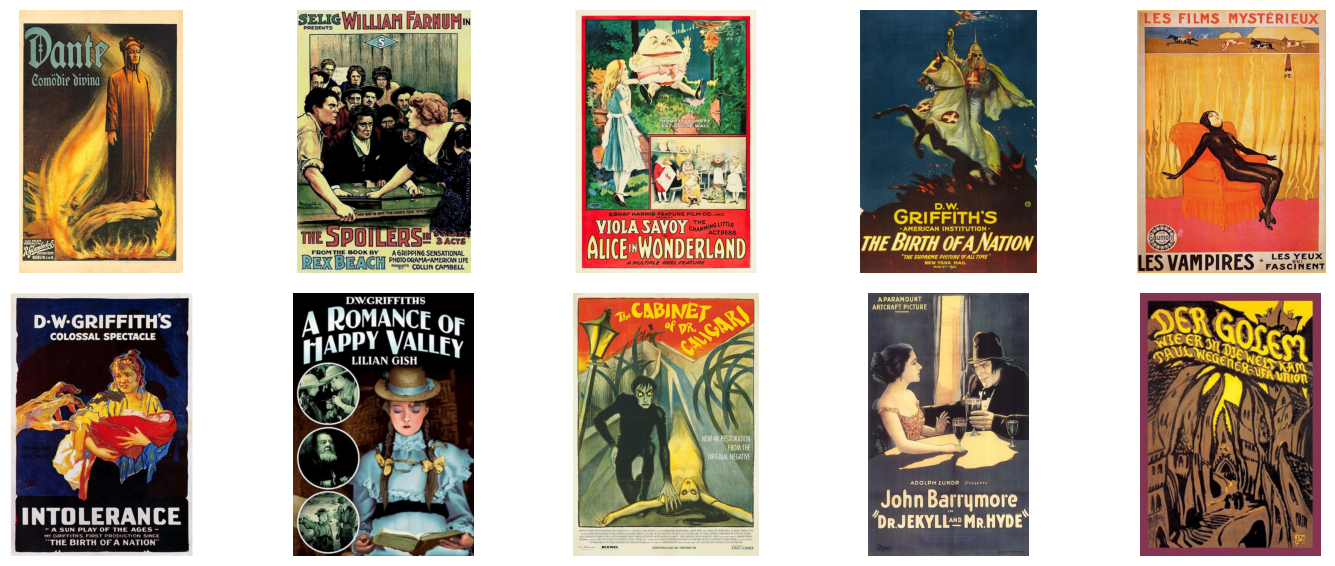

In [ ]:
# cf_model = load_model("../models/rismf_model_nf2_lr0.01.pkl")
# cf_model.print_recommendation('ur127508339')

# BRISMF

In [ ]:
class BRISMF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10):
        self.train_data = train_data
        self.test_data = test_data
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.n_epochs = n_epochs
        self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1
         
        # P, Q's size may be big at first to add new user/film
        self.P = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_users + 100, self.n_factors))
        self.Q = np.random.normal(scale=1.0 / self.n_factors, size=(self.n_movies + 100, self.n_factors))
        
        # Fix P[1, :] and Q[2, :] to 1
        self.P[1, :] = 1
        self.Q[2, :] = 1
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def fit(self):
        best_loss = float('inf')
        no_improve_epochs = 0
        
        for epoch in range(self.n_epochs):
            np.random.shuffle(self.train_data)
            # Use tqdm to create a progress bar for the inner loop
            for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
                u, i = int(u), int(i)
                pred = self.pred(u, i)
                error = r - pred
                
                # Skip updates for fixed rows
                if u != 1:
                    self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
                if i != 2:
                    self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])
            
            train_loss = self.loss(self.train_data)
            test_loss = self.loss(self.test_data)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Test loss: {test_loss:.4f}")
            
            # Early stopping logic
            if test_loss < best_loss + 1e-6:
                best_loss = test_loss
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                if no_improve_epochs >= 5:
                    print("Early stopping: No improvement for 5 consecutive epochs.")
                    break
                
    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])

        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        # Incremental learning using new ratings
        for u, i, r in processed_ratings:
            u, i, r = int(u), int(i), int(r)
            pred = self.pred(u, i)
            error = r - pred
            
            if u != 1:
                self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
            if i != 2:
                self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

    def pred(self, u, i):
        return self.P[u, :].dot(self.Q[i, :].T)
            
    def print_recommendation(self, user_id, number=10):
        recommended_items = self.recommend(user_id_to_number[user_id])
        recommended_items = recommended_items[:number]
        
        print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
        cols = 5 if number > 5 else number
        rows = math.ceil(number/cols)

        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        urls = []

        for i in recommended_items:
            movie_id = number_to_movie_id[i]
            urls.append(get_movieURL(movie_id))
            
        for i, ax in enumerate(axes.flat):
            if i < number:
                ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                fig.tight_layout()
                ax.axis('off')
            else:
                ax.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)
        print(recommended_items)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def loss(self, data):
        L = 0
        for u, i, r in (data):
            u, i = int(u), int(i)
            pred = self.pred(u, i)
            L += (r - pred)**2
        L /= data.shape[0]
        return math.sqrt(L)

In [ ]:
# Hyperparameter grid
n_factors_list = [5, 10, 20, 50] # [5, 10, 20, 50]
learning_rates = [1e-3, 1e-2, 5e-2, 1e-1] # [1e-3, 1e-2, 5e-2, 1e-1]

# Open the CSV file and write the header once
csv_file_path = '../results/brismf_results.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Evaluate across all hyperparameter combinations
for n_factors, learning_rate in product(n_factors_list, learning_rates):
    # Initialize the model
    cf_model = BRISMF(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
    print(f"brismf, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
    # Train the model
    cf_model.fit()
    
    # Evaluate the model
    hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
    print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
    # Save the model
    model_filename = f"../models/brismf/brismf_nf{n_factors}_lr{learning_rate}.pkl"
    cf_model.save(model_filename)
    
    # Append the result to the CSV file
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
        writer.writerow({
            'n_factors': n_factors, 
            'learning_rate': learning_rate, 
            'HR': f"{hit_ratio:.4f}", 
            'NDCG': f"{ndcg:.4f}"
        })

In [ ]:
# class RISMF_uniform_init_Adam(object):
#     global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
#     def __init__(self, train_data, test_data, n_factors=10, learning_rate=0.01, lambda_reg=0.1, n_epochs=10, beta1=0.9, beta2=0.999, epsilon=1e-8):
#         self.train_data = train_data
#         self.test_data = test_data
#         self.n_factors = n_factors
#         self.learning_rate = learning_rate
#         self.lambda_reg = lambda_reg
#         self.n_epochs = n_epochs
#         self.n_users = int(np.max(self.train_data[:, 0])) + 1 # 1 because index from 0
#         self.n_movies = int(np.max(self.train_data[:, 1])) + 1
         
#         # P, Q's size may be big at first to add new user/film
#         self.P = np.random.uniform(-0.01, 0.01, size=(self.n_users + 100, self.n_factors))
#         self.Q = np.random.uniform(-0.01, 0.01, size=(self.n_movies + 100, self.n_factors))
        
#         self.beta1 = beta1
#         self.beta2 = beta2
#         self.epsilon = epsilon
        
#         # Adam-specific parameters for P and Q
#         self.m_P = np.zeros_like(self.P)
#         self.v_P = np.zeros_like(self.P)
#         self.m_Q = np.zeros_like(self.Q)
#         self.v_Q = np.zeros_like(self.Q)
        
#         self.t = 0  # Adam timestep
    
#     def save(self, filename):
#         with open(filename, 'wb') as f:
#             pickle.dump(self, f)

#     def fit(self):
#         best_loss = float('inf')
#         no_improve_epochs = 0
        
#         for epoch in range(self.n_epochs):
#             np.random.shuffle(self.train_data)
#             self.t += 1  # Increment timestep for Adam
            
#             # Use tqdm to create a progress bar for the inner loop
#             for u, i, r in tqdm(self.train_data, desc=f'Epoch {epoch + 1}/{self.n_epochs}', unit='rating'):
#                 u, i = int(u), int(i)
#                 pred = self.pred(u, i)
#                 error = r - pred
                
#                 # Gradients for P and Q
#                 grad_P = -error * self.Q[i, :] + self.lambda_reg * self.P[u, :]
#                 grad_Q = -error * self.P[u, :] + self.lambda_reg * self.Q[i, :]
                
#                 # Adam update for P
#                 self.m_P[u, :] = self.beta1 * self.m_P[u, :] + (1 - self.beta1) * grad_P
#                 self.v_P[u, :] = self.beta2 * self.v_P[u, :] + (1 - self.beta2) * (grad_P ** 2)
#                 m_P_corrected = self.m_P[u, :] / (1 - self.beta1 ** self.t)
#                 v_P_corrected = self.v_P[u, :] / (1 - self.beta2 ** self.t)
#                 self.P[u, :] -= self.learning_rate * m_P_corrected / (np.sqrt(v_P_corrected) + self.epsilon)
                
#                 # Adam update for Q
#                 self.m_Q[i, :] = self.beta1 * self.m_Q[i, :] + (1 - self.beta1) * grad_Q
#                 self.v_Q[i, :] = self.beta2 * self.v_Q[i, :] + (1 - self.beta2) * (grad_Q ** 2)
#                 m_Q_corrected = self.m_Q[i, :] / (1 - self.beta1 ** self.t)
#                 v_Q_corrected = self.v_Q[i, :] / (1 - self.beta2 ** self.t)
#                 self.Q[i, :] -= self.learning_rate * m_Q_corrected / (np.sqrt(v_Q_corrected) + self.epsilon)
            
#             train_loss = self.loss(self.train_data)
#             test_loss = self.loss(self.test_data)
#             print(f"Train loss: {train_loss:.4f}")
#             print(f"Test loss: {test_loss:.4f}")
            
#             # Early stopping logic
#             if test_loss < best_loss + 1e-6:
#                 best_loss = test_loss
#                 no_improve_epochs = 0
#             else:
#                 no_improve_epochs += 1
#                 if no_improve_epochs >= 5:
#                     print("Early stopping: No improvement for 5 consecutive epochs.")
#                     break

#     def incremental_update(self, new_ratings):
#         # Convert new_ratings from IDs to numerical indices
#         processed_ratings = []
#         for user_id, movie_id, rating in new_ratings:
#             # Check and update user_id_to_number
#             if user_id not in user_id_to_number:
#                 user_id_to_number[user_id] = self.n_users
#                 number_to_user_id[self.n_users] = user_id
#                 self.n_users += 1

#             # Check and update movie_id_to_number
#             if movie_id not in movie_id_to_number:
#                 movie_id_to_number[movie_id] = self.n_movies
#                 number_to_movie_id[self.n_movies] = movie_id
#                 self.n_movies += 1

#             # Convert IDs to numbers and append to processed_ratings
#             u = user_id_to_number[user_id]
#             i = movie_id_to_number[movie_id]
#             processed_ratings.append([u, i, rating])

#         # Convert processed_ratings to a NumPy array
#         processed_ratings = np.array(processed_ratings)
#         # Update the train_data matrix with the new ratings
#         self.train_data = np.vstack((self.train_data, processed_ratings))
#         # Incremental learning using new ratings
#         for u, i, r in processed_ratings:
#             u, i, r = int(u), int(i), int(r)
#             pred = self.pred(u, i)
#             error = r - pred
#             # Update P and Q
#             self.P[u, :] += self.learning_rate * (error * self.Q[i, :] - self.lambda_reg * self.P[u, :])
#             self.Q[i, :] += self.learning_rate * (error * self.P[u, :] - self.lambda_reg * self.Q[i, :])

#     def pred(self, u, i):
#         return self.P[u, :].dot(self.Q[i, :].T)
            
#     def print_recommendation(self, user_id, number=10):
#         recommended_items = self.recommend(user_id_to_number[user_id])
#         recommended_items = recommended_items[:number]
        
#         print(f'Recommended movie(s) for user {user_id} : {recommended_items}')
            
#         cols = 5 if number > 5 else number
#         rows = math.ceil(number/cols)

#         fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
#         urls = []

#         for i in recommended_items:
#             movie_id = number_to_movie_id[i]
#             urls.append(get_movieURL(movie_id))
            
#         for i, ax in enumerate(axes.flat):
#             if i < number:
#                 ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
#                 fig.tight_layout()
#                 ax.axis('off')
#             else:
#                 ax.axis('off')
            
#     def recommend(self, u):        
#         """
#         Determine all unrated items should be recommended for user u
#         """
#         ids = np.where(self.train_data[:, 0] == u)[0]
#         items_rated_by_u = self.train_data[ids, 1].tolist()
#         recommended_items = {}
#         for i in range(self.n_movies):
#             if i not in items_rated_by_u:
#                 recommended_items[i] = self.pred(u, i)

#         return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
#     def loss(self, data):
#         L = 0
#         for u, i, r in (data):
#             u, i = int(u), int(i)
#             pred = self.pred(u, i)
#             L += (r - pred)**2
#         L /= data.shape[0]
#         return math.sqrt(L)

In [ ]:
# # Hyperparameter grid
# n_factors_list = [5, 10, 20, 50] # [5, 10, 20, 50]
# learning_rates = [1e-3, 1e-2, 5e-2, 1e-1] # [1e-3, 1e-2, 5e-2, 1e-1]

# # Open the CSV file and write the header once
# csv_file_path = '../results/rismf_uniform_init_adam_results.csv'
# with open(csv_file_path, 'w', newline='') as csvfile:
#     fieldnames = ['n_factors', 'learning_rate', 'HR', 'NDCG']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()

# # Evaluate across all hyperparameter combinations
# for n_factors, learning_rate in product(n_factors_list, learning_rates):
#     # Initialize the model
#     cf_model = RISMF_uniform_init_Adam(train_data, val_data, n_factors=n_factors, learning_rate=learning_rate, lambda_reg=0.1, n_epochs=100)
#     print(f"rismf_uniform_init_adam, n_factors: {n_factors}, learning_rate: {learning_rate}")
    
#     # Train the model
#     cf_model.fit()
    
#     # Evaluate the model
#     hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top=5)
#     print(f"Results - n_factors: {n_factors}, learning_rate: {learning_rate}, HR: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")
    
#     # Save the model
#     model_filename = f"../models/rismf_uniform_init_adam/rismf_uniform_init_adam_nf{n_factors}_lr{learning_rate}.pkl"
#     cf_model.save(model_filename)
    
#     # Append the result to the CSV file
#     with open(csv_file_path, 'a', newline='') as csvfile:
#         writer = csv.DictWriter(csvfile, fieldnames=['n_factors', 'learning_rate', 'HR', 'NDCG'])
#         writer.writerow({
#             'n_factors': n_factors, 
#             'learning_rate': learning_rate, 
#             'HR': f"{hit_ratio:.4f}", 
#             'NDCG': f"{ndcg:.4f}"
#         })